In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import utils
import gpfunctions as gp
import lstm_model
import benchmarkfunctions as bm
import skopt
import scipy

In [2]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
LOSS_FUNCS = ['MIN','SUMMIN']
BASELINES = ['SKOPT', 'RANDOM']
DIMS = [2,3,4,6]
N_STEPS = 20

In [4]:
FUNCTIONS = {
    #TODO : 1d, 4d, 6d
    '2d': bm.goldstein_price,
    '2d_tf': bm.goldstein_price_tf,
    '3d': bm.hartmann3,
    '3d_tf': bm.hartmann3_tf,
    '6d': bm.hartmann6,
    '6d_tf': bm.hartmann6_tf
}

In [5]:
def get_y_from_skopt(dim, n_start_random=10, runs=10, func=None):
    if func==None:
        obj_func =  lambda x : float(FUNCTIONS['%dd'%(dim)](x))
    else:
        obj_func =  lambda x : float(func(x))
    data = []
    for i in range(runs):
        res = skopt.gp_minimize(obj_func, [(-1.0, 1.0)]*dim, n_calls=N_STEPS+1, x0=[-1]*dim)
        data.append(res.func_vals)
    return np.mean(np.array(data),axis=0)

def get_y_from_random(dim, steps, runs=10, func=None):
    data = []
    for i in range(runs):
        x = np.random.uniform(-1,1,(dim,steps))
        x[:, 0] = [-1]*dim
        if func==None:
            y = np.apply_along_axis(FUNCTIONS['%dd'%(dim)], 0, x)
        else:
            y = np.apply_along_axis(func, 0, x)
        data.append(y.T)
    return np.mean(np.array(data),axis=0)

In [6]:
def get_y_from_lstm(kernel, dim, loss, func, n_steps=20, debug=False):
    
    model = utils.get_trained_model(dim=dim, kernel=kernel, loss=loss)    
    starting_point = utils.loadConfig()['experiments']['%dD'%dim]['hyperparameters']['starting_point'][0]

    model_params = lstm_model.load_model_params(model, debug=False)

    res = None
    with tf.Session() as sess:

        lstm_params = {
            'dim' : model_params['dim'],
            'n_hidden': model_params['n_hidden'],
            'forget_bias': model_params['forget_bias'],
            'scope': model_params['scope']
        }
        cell, weights = lstm_model.get_lstm_weights(**lstm_params)
        
        saver = tf.train.Saver()
        saver.restore(sess, model_params['model_path'])

        benchmark_samples_params = {
            'f': func,
            'cell': cell,
            'weights': weights,
            'dim': model_params['dim'],
            'n_hidden': model_params['n_hidden'],
            'n_steps': model_params['n_steps'],
            'scope': model_params['scope'],
            'batch_size': 1
        }
        
        samples_benchmark_x, samples_benchmark_y, x_0 = lstm_model.apply_lstm_model(**benchmark_samples_params)
    
        feed_dict = {
            x_0: np.array(starting_point).reshape(1,-1)
        }
        sample_y, sample_x = sess.run([samples_benchmark_y, samples_benchmark_x], feed_dict=feed_dict)
        sample_y = np.array(sample_y).reshape(-1,1).T
        sample_x = np.array(sample_x).reshape(-1,1, model_params['dim']).transpose((1,0,2)).reshape(-1,model_params['dim'])
        return sample_y.T

In [7]:
def plot_for_dim(dim):
    data = {}
    data['SKOPT']  = utils.min_up_to_k(get_y_from_skopt(dim))
    data['RANDOM'] = utils.min_up_to_k(get_y_from_random(dim, steps = N_STEPS+1))
    
    for k in BASELINES:
        plt.plot(data[k], label=k)
        
    for kernel in ['rbf', 'matern32']:
        for loss in LOSS_FUNCS:
            y = get_y_from_lstm(kernel, dim, loss, FUNCTIONS['%dd_tf'%(dim)])
            y = utils.min_up_to_k(y)
            plt.plot(y, label='LSTM-%s-%s'%(loss, kernel.upper()))
        
    xticks = range(0,N_STEPS+1,2)
    plt.ylabel('Min Found')
    plt.xlabel('Evaluation Step')
    plt.xticks(xticks)
    plt.ylim(-1)
    plt.title('%dD' % dim)
    plt.legend()
    plt.plot()
    
#plot_for_dim(2)

In [8]:
def plot_for_fun(fun, fun_tf, n_runs, dim):
    data = {}
    for i in range(n_runs):
        print("Run ",i+1,"/",n_runs)
        # Shift function = Random Starting point
        x0 = np.random.normal(size=dim, scale=0.2)
        # Flip function
        flip = 1#np.random.choice([-1.0,1.0])
        # Shift up and down
        y0 = np.random.normal(size=1, scale=0.2)
        
        if i==0:
            data['SKOPT']  = [utils.min_up_to_k(get_y_from_skopt(dim, func=lambda x : float(y0+fun(flip*x+x0))))]
            data['RANDOM'] = [utils.min_up_to_k(get_y_from_random(dim, steps = N_STEPS+1,
                                                                  func= lambda x : float(y0+fun(flip*x+x0))))]
            for loss in LOSS_FUNCS:
                data[loss] = [utils.min_up_to_k(get_y_from_lstm('rbf', dim, loss, 
                                                                lambda x : y0+fun_tf(flip*x+x0)))]
        else:
            data['SKOPT']  += [utils.min_up_to_k(get_y_from_skopt(dim, func=lambda x : float(y0+fun(flip*x+x0))))]
            data['RANDOM'] += [utils.min_up_to_k(get_y_from_random(dim, steps = N_STEPS+1,
                                                                  func= lambda x : float(y0+fun(flip*x+x0))))]
            for loss in LOSS_FUNCS:
                data[loss] += [utils.min_up_to_k(get_y_from_lstm('rbf', dim, loss, 
                                                                lambda x : y0+fun_tf(flip*x+x0)))]
        
    return data
        
    
    
def plot_results(data, dim=2):
    for k in data.keys():
        plt.plot(np.mean(np.array(data[k]),axis=0), label=k)
        
    xticks = range(0,N_STEPS+1,2)
    plt.ylabel('Min Found')
    plt.xlabel('Evaluation Step')
    plt.xticks(xticks)
    plt.ylim(-1)
    plt.title('%dD' % dim)
    plt.legend()
    plt.plot()


In [ ]:
#data = plot_for_fun(bm.parabolasin, bm.parabolasin_tf , 10, dim=2)

In [ ]:
plot_results(data)

In [ ]:
plot_for_dim(3)

In [ ]:
plot_for_dim(6)

In [ ]:
count = 0
plt.figure(figsize=(15,4*2))
for d in [2,3,3,6]:
    plt.subplot(2,2,count + 1 )
    plot_for_dim(d)
    count = count + 1
plt.tight_layout()

Function  1 / 1
Function  1 / 1


C:\Users\User\Anaconda3\envs\tensorflow\lib\site-packages\skopt\optimizer\optimizer.py:195: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\Anaconda3\envs\tensorflow\lib\site-packages\skopt\optimizer\optimizer.py:195: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


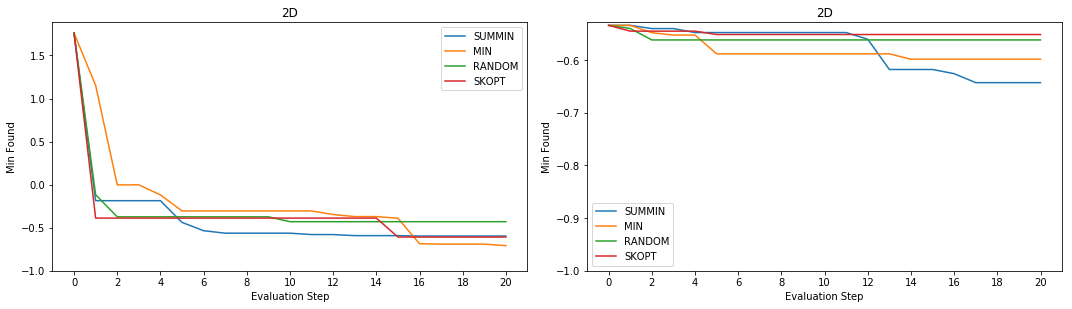

In [10]:
count = 0
plt.figure(figsize=(15,4*2))
for fun, fun_tf, dim in zip([bm.parabolasin, bm.hartmann3, bm.styblinski4, bm.hartmann6],
                           [bm.parabolasin_tf, bm.hartmann3_tf, bm.styblinski4_tf, bm.hartmann6_tf],[2,3,4,6]):
    print(fun)
    plt.subplot(2,2,count + 1 )
    data = plot_for_fun(fun, fun_tf , 10, dim)
    plot_results(data, dim)
    count = count + 1
plt.tight_layout()